

## **GI-Net**
## Classification of Anomalies in the Gastrointestinal Tract using Deep Learning
Trained on the KVASIR dataset


In [ ]:
# Necessary imports

import cv2
import glob
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras import applications
from tensorflow.keras import optimizers
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.decomposition import TruncatedSVD


## Loading the dataset

#### Download the dataset and extract the class folders

In [ ]:
!wget https://datasets.simula.no/kvasir/data/kvasir-dataset-v2.zip

--2021-03-19 08:36:00--  https://datasets.simula.no/kvasir/data/kvasir-dataset-v2.zip
Resolving datasets.simula.no (datasets.simula.no)... 128.39.36.14
Connecting to datasets.simula.no (datasets.simula.no)|128.39.36.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2489312085 (2.3G) [application/zip]
Saving to: ‘kvasir-dataset-v2.zip’

kvasir-dataset-v2.z 100%[===================>]   2.32G  18.3MB/s    in 2m 13s  

2021-03-19 08:38:14 (17.8 MB/s) - ‘kvasir-dataset-v2.zip’ saved [2489312085/2489312085]



In [ ]:
!unzip "/content/kvasir-dataset-v2.zip"

Streaming output truncated to the last 5000 lines.
  inflating: kvasir-dataset-v2/normal-pylorus/79b990c2-870b-4cdd-8d8d-ad7ea33e0258.jpg  
  inflating: kvasir-dataset-v2/normal-pylorus/af744492-dc36-4f70-95e8-9056c462eaca.jpg  
  inflating: kvasir-dataset-v2/normal-pylorus/7f607ea9-1c1a-4e65-9888-7db35c807f59.jpg  
  inflating: kvasir-dataset-v2/normal-pylorus/c777b21e-9dc0-4179-a849-455044cb0d2c.jpg  
  inflating: kvasir-dataset-v2/normal-pylorus/9a824235-7dda-494b-8213-a1185ac7d7ab.jpg  
  inflating: kvasir-dataset-v2/normal-pylorus/b9559ef9-163d-4d98-a8d4-5f058bfa8003.jpg  
  inflating: kvasir-dataset-v2/normal-pylorus/3f429284-8727-43df-800a-6bfc84e71cc2.jpg  
  inflating: kvasir-dataset-v2/normal-pylorus/dabd496e-b1b0-4c25-aebb-a65a8fe4739c.jpg  
  inflating: kvasir-dataset-v2/normal-pylorus/5c1e245c-c69e-42e5-a5b3-fcfba78b667f.jpg  
  inflating: kvasir-dataset-v2/normal-pylorus/32b4ac97-2c27-4059-aa53-c304fdc2cc50.jpg  
  inflating: kvasir-dataset-v2/normal-pylorus/1d9233e5-05fb

In [ ]:
from pathlib import Path

p = Path('kvasir-dataset-v2')
category_dirs = [x for x in p.rglob('*') if x.is_dir()]
categories = [x.name for x in category_dirs]

In [ ]:
print("Number of categories:", len(categories))

Number of categories: 8


In [ ]:
categories

['normal-z-line',
 'esophagitis',
 'dyed-resection-margins',
 'polyps',
 'ulcerative-colitis',
 'dyed-lifted-polyps',
 'normal-cecum',
 'normal-pylorus']

In [ ]:
datadir='/content/kvasir-dataset-v2'

In [ ]:
test_img = cv2.imread('kvasir-dataset-v2/ulcerative-colitis/c7e11a23-a8b0-4d29-a178-c92e862f39f1.jpg')

In [ ]:
test_img.shape

(576, 720, 3)

In [ ]:
img_size = 224

#### Creating tf.data.Dataset objects

Since the dataset is too large to fit in memory, a tf.data.Dataset object is created that will load the images from disk during training



In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  datadir,
  validation_split=0.2,
  subset="training",
  label_mode = 'categorical',
  seed=123,
  image_size=(img_size, img_size),
  batch_size=32)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  datadir,
  validation_split=0.2,
  subset="validation",
  label_mode = 'categorical',
  seed=123,
  image_size=(img_size, img_size),
  batch_size=32)

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Found 8000 files belonging to 8 classes.
Using 1600 files for validation.


## Exploratory data analysis

#### Example images from the dataset

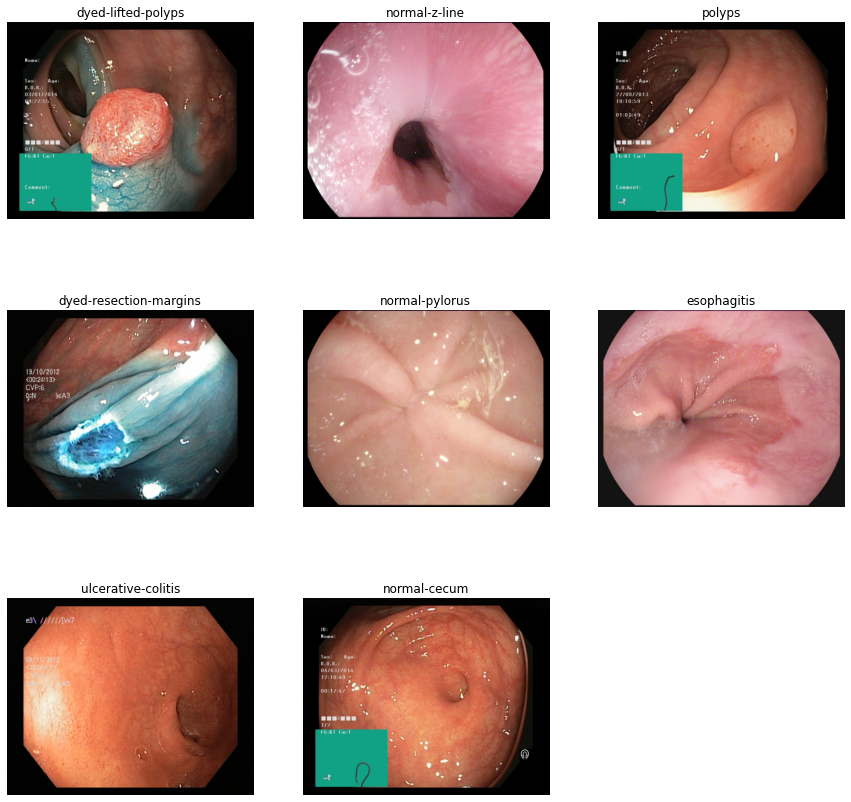

In [ ]:
# Show one example for each category

plt.figure(figsize=(15, 15))
plot_num = 1
for cat_dir in category_dirs:
  img_path = random.choice(os.listdir(cat_dir))
  img = cv2.imread(os.path.join(cat_dir,img_path))
  ax = plt.subplot(3, 3, plot_num)
  plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
  plt.title(cat_dir.name)
  plt.axis("off")
  plot_num+=1



#### Number of instances in each category

In [ ]:
category_counts = {}
for cat_dir in category_dirs:
  category_counts[cat_dir.name] = len(list(cat_dir.glob("*.jpg")))

In [ ]:
category_counts = pd.DataFrame.from_dict(category_counts, orient = "index", columns = ["count"])

In [ ]:
category_counts.sort_values("count")

,count
dyed-lifted-polyps,1000
normal-z-line,1000
polyps,1000
dyed-resection-margins,1000
normal-pylorus,1000
esophagitis,1000
ulcerative-colitis,1000
normal-cecum,1000


The dataset is **perfectly balanced**

## Creating the model

#### Loading a pretrained CNN model

In [ ]:
model1 = applications.DenseNet201(weights = "imagenet", include_top=False, input_shape = (img_size,img_size, 3))
model2 = applications.InceptionResNetV2(weights = "imagenet", include_top=False, input_shape = (img_size,img_size, 3))
model3 = applications.VGG16(weights = "imagenet", include_top=False, input_shape = (img_size,img_size, 3))

58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
print("Number of layers in model1: ",len(model1.layers))
print("Number of layers in model2: ",len(model2.layers))
print("Number of layers in model3: ",len(model3.layers))

Number of layers in model1:  707
Number of layers in model2:  780
Number of layers in model3:  19


In [ ]:
model1.summary()

Model: "densenet201"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [ ]:
model2.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
________________________________________________________________________________

In [ ]:
model3.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

All the layers of the model are made trainable

In [ ]:
for layer in model1.layers:
    layer.trainable=True

for layer in model2.layers:
    layer.trainable = True

for layer in model3.layers:
    layer.trainable=True

#### Creating a data augmentation pipeline

In [ ]:
# Custom data augmentation layer to randomly change brightness of the image. However, using random brightness worsens model performance

class RandomBrightness(tf.keras.layers.Layer):
    def __init__(self, brightness_delta, **kwargs):
        super(RandomBrightness, self).__init__(**kwargs)
        self.brightness_delta = brightness_delta

    def call(self, images, training=None):
        if not training:
            return images
        
        brightness = np.random.uniform(
            -self.brightness_delta, self.brightness_delta)
        
        images = tf.image.adjust_brightness(images, brightness)
        return images

In [ ]:
data_augmentation = tf.keras.Sequential(
  [
    # RandomBrightness(0.3),
    layers.experimental.preprocessing.RandomContrast(0.3),
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_size, 
                                                              img_size,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
  ]
)

#### Compiling the final model

In [ ]:
metrics = ["accuracy",
           tf.keras.metrics.Precision(),
           tf.keras.metrics.Recall(),
           tf.keras.metrics.AUC(),
           tf.keras.metrics.TruePositives(),
           tf.keras.metrics.TrueNegatives(),
           tf.keras.metrics.FalsePositives(),
           tf.keras.metrics.FalseNegatives()
           ]

In [ ]:
inputs = tf.keras.Input(shape=(img_size,img_size,3))
augmented = data_augmentation(inputs)
model1_input = tf.keras.applications.densenet.preprocess_input(augmented)
model2_input = tf.keras.applications.inception_resnet_v2.preprocess_input(augmented)
model3_input = tf.keras.applications.vgg16.preprocess_input(augmented)
output1 = model1(model1_input)
output2 = model2(model2_input)
output3 = model3(model3_input)
x1 =  tf.keras.layers.GlobalAveragePooling2D()(output1)
x2 =  tf.keras.layers.GlobalAveragePooling2D()(output2)
x3 =  tf.keras.layers.GlobalAveragePooling2D()(output3)
concatenated = tf.keras.layers.concatenate([x1,x2,x3])

x = tf.keras.layers.Dense(128,activation="relu")(concatenated)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
predictions = tf.keras.layers.Dense(len(categories), activation="softmax")(x)

model_final = tf.keras.Model(inputs=inputs, outputs=predictions)

In [ ]:
model_final.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.001, momentum=0.9),metrics=metrics)

In [ ]:
model_final.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 224, 224, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
tf.math.truediv (TFOpLambda)    (None, 224, 224, 3)  0           sequential[0][0]                 
__________________________________________________________________________________________________
tf.nn.bias_add (TFOpLambda)     (None, 224, 224, 3)  0           tf.math.truediv[0][0]            
______________________________________________________________________________________________

## Training

In [ ]:
# Creating callbacks to be used during training

anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, verbose=1, min_lr=1e-4)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [25]:
history=model_final.fit(train_ds.prefetch(tf.data.AUTOTUNE).cache(),
          epochs=30,
          verbose=1,
          validation_data=val_ds.prefetch(tf.data.AUTOTUNE).cache(),
          callbacks = [anne,checkpoint,early_stopping])

Epoch 1/30
200/200 [==============================] - 264s 966ms/step - loss: 1.5132 - accuracy: 0.4184 - precision: 0.5652 - recall: 0.2288 - auc: 0.8133 - true_positives: 1008.4577 - true_negatives: 22159.2189 - false_positives: 463.6667 - false_negatives: 2223.3831 - val_loss: 0.4544 - val_accuracy: 0.8213 - val_precision: 0.8382 - val_recall: 0.8000 - val_auc: 0.9833 - val_true_positives: 1280.0000 - val_true_negatives: 10953.0000 - val_false_positives: 247.0000 - val_false_negatives: 320.0000

Epoch 00001: val_loss improved from inf to 0.45441, saving model to model.h5
Epoch 2/30
200/200 [==============================] - 174s 872ms/step - loss: 0.5282 - accuracy: 0.8034 - precision: 0.8256 - recall: 0.7554 - auc: 0.9778 - true_positives: 2503.3184 - true_negatives: 22142.1990 - false_positives: 480.6866 - false_negatives: 728.5224 - val_loss: 0.2978 - val_accuracy: 0.8844 - val_precision: 0.8895 - val_recall: 0.8756 - val_auc: 0.9925 - val_true_positives: 1401.0000 - val_true_neg

After training for a total of 12 epochs, the best validation accuracy is **92.75%**. After epoch 7, the model starts overfitting.


## Load saved model to continue training

If a saved model exists, it can be loaded and training can start from where it was left off

In [ ]:
save_dir = "/content/gdrive/MyDrive/Models/Kvasir-Capsule-DenseNet201.h5"

In [ ]:
saved_model = tf.keras.models.load_model(save_dir)

In [ ]:
# Creating callbacks to be used during training

anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, verbose=1, min_lr=1e-4)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)

In [ ]:
history =  saved_model.fit(train_ds.prefetch(tf.data.AUTOTUNE),
              epochs=10,
              verbose=1,
              validation_data=val_ds.prefetch(tf.data.AUTOTUNE),
              callbacks = [anne,checkpoint])

## Visualizing training history

In [26]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'auc', 'true_positives', 'true_negatives', 'false_positives', 'false_negatives', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc', 'val_true_positives', 'val_true_negatives', 'val_false_positives', 'val_false_negatives', 'lr'])

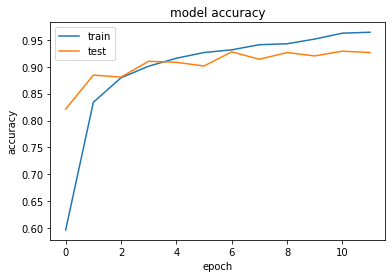

In [27]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

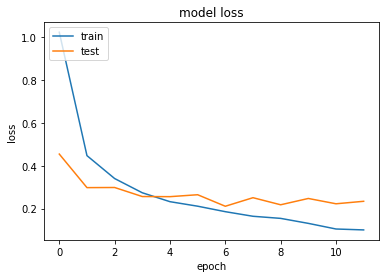

In [28]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Evaluating the final model

#### Load model

In [29]:
final_model_dir = "/content/model.h5"

In [30]:
final_model = tf.keras.models.load_model(final_model_dir)

#### Evaluation

In [31]:
final_model.evaluate(val_ds)

50/50 [==============================] - 36s 531ms/step - loss: 0.2108 - accuracy: 0.9275 - precision: 0.9298 - recall: 0.9275 - auc: 0.9949 - true_positives: 1484.0000 - true_negatives: 11088.0000 - false_positives: 112.0000 - false_negatives: 116.0000


[0.21083496510982513,
 0.9275000095367432,
 0.9298245906829834,
 0.9275000095367432,
 0.9948635101318359,
 1484.0,
 11088.0,
 112.0,
 116.0]

The final model has **92.75%** accuracy, with a precision of **92.98%** and a recall of **92.75%**

#### Confusion matrix and classification report

Since tf.data.Dataset does not fetch images from disk in the same order, so we need to load the validation dataset into memory for consistency

In [32]:
x = []
y = []
for image,label in val_ds:
  x.append(image)
  y.append(label)

In [33]:
x = np.array(x)
y = np.array(y)

print(x.shape)
print(y.shape)

(50, 32, 224, 224, 3)
(50, 32, 8)


In [34]:
x = np.reshape(x,(x.shape[0]*x.shape[1],224,224,3))
y = np.reshape(y,(y.shape[0]*y.shape[1],y.shape[2]))

In [35]:
# Making predictions on the validation dataset
y_pred = final_model.predict(x)

In [36]:
predicted_categories = tf.argmax(y_pred, axis=-1)

In [37]:
true_categories = tf.argmax(y, axis=-1)

**The classification report**

In [38]:
print(classification_report(true_categories, predicted_categories))

              precision    recall  f1-score   support

           0       0.92      0.97      0.95       196
           1       0.98      0.92      0.95       209
           2       0.86      0.82      0.84       203
           3       0.97      0.99      0.98       212
           4       0.93      1.00      0.97       199
           5       0.81      0.82      0.82       185
           6       0.97      0.93      0.95       195
           7       0.97      0.96      0.96       201

    accuracy                           0.93      1600
   macro avg       0.93      0.93      0.93      1600
weighted avg       0.93      0.93      0.93      1600



The final model has an **f1-score** of **0.93**

**The confusion matrix**

In [39]:
conf_matrix = confusion_matrix(true_categories, predicted_categories)
print(conf_matrix)

[[191   3   0   0   0   0   1   1]
 [ 17 192   0   0   0   0   0   0]
 [  0   0 166   0   2  35   0   0]
 [  0   0   0 209   0   0   3   0]
 [  0   0   0   0 199   0   0   0]
 [  0   0  27   0   6 152   0   0]
 [  0   0   0   3   5   0 182   5]
 [  0   0   1   4   1   0   2 193]]


Plotting the confusion matrix using Seaborn



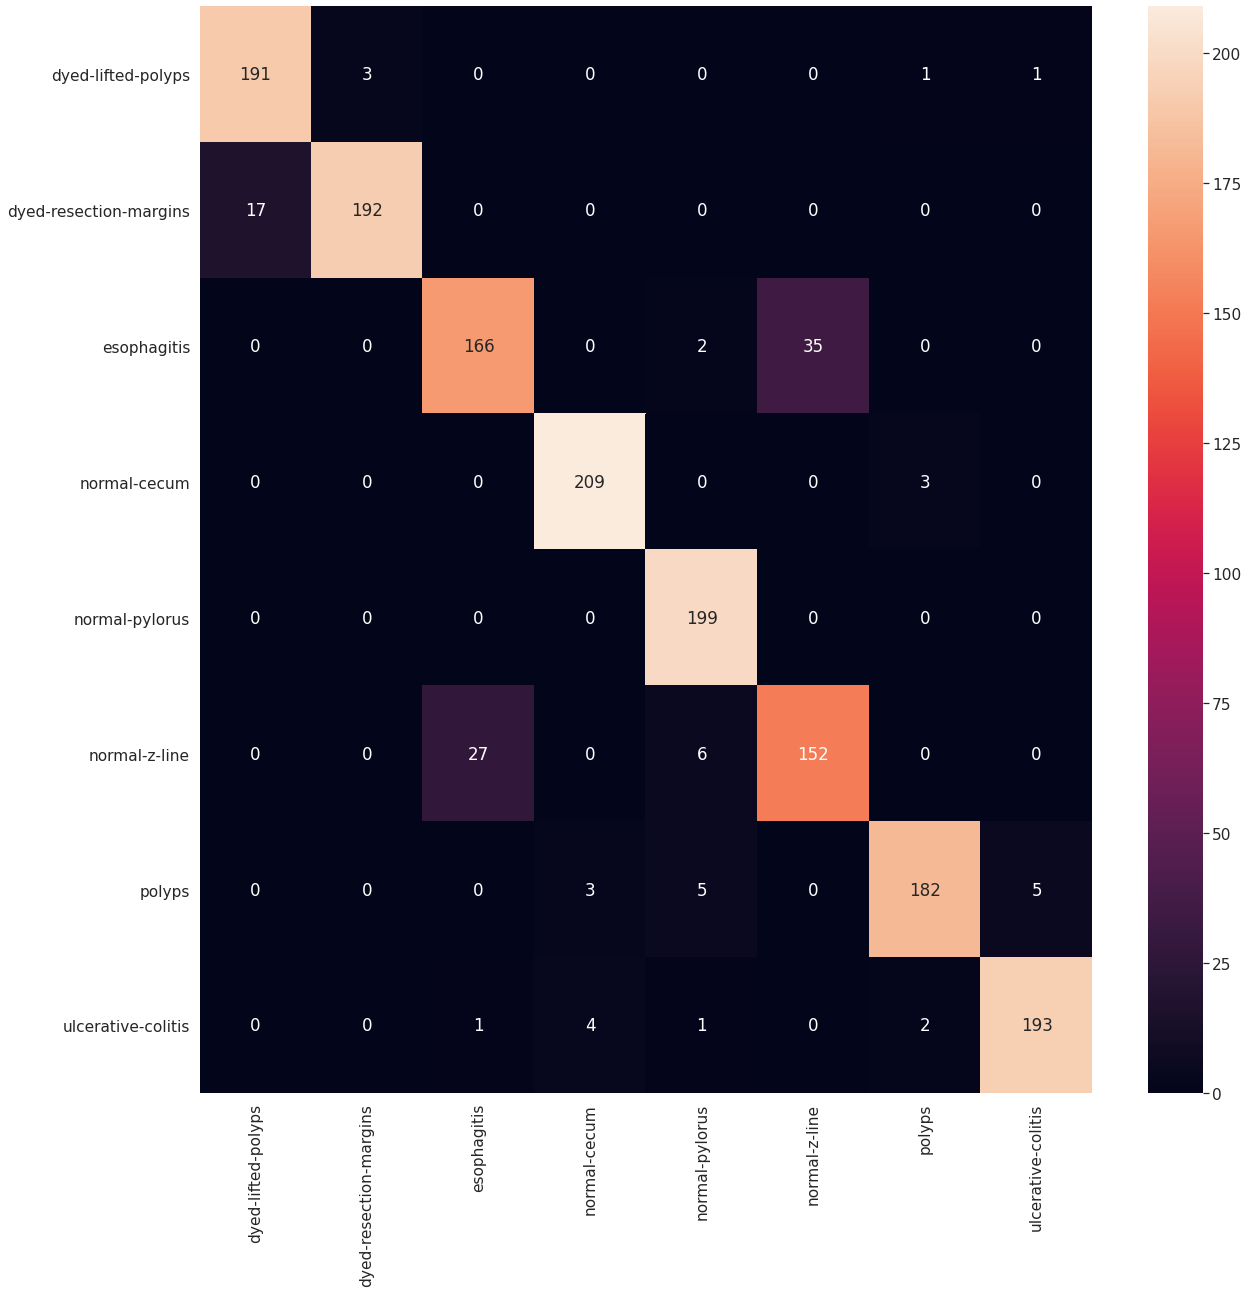

In [40]:
df_cm = pd.DataFrame(conf_matrix, val_ds.class_names, val_ds.class_names)
plt.figure(figsize=(20,20))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True,fmt='g') # font size

plt.show()

It is visible that the  model has not overfit and that even classes with only 10 instances in the dataset have been predicted accurately

#### Save the model file to Google Drive

In [46]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [42]:
!mv "model.h5" "GI-NetV2-927.h5"

In [43]:
!mv "GI-NetV2-927.h5" "/content/gdrive/MyDrive/Models"

In [44]:
drive.flush_and_unmount()

## Visualizing the model

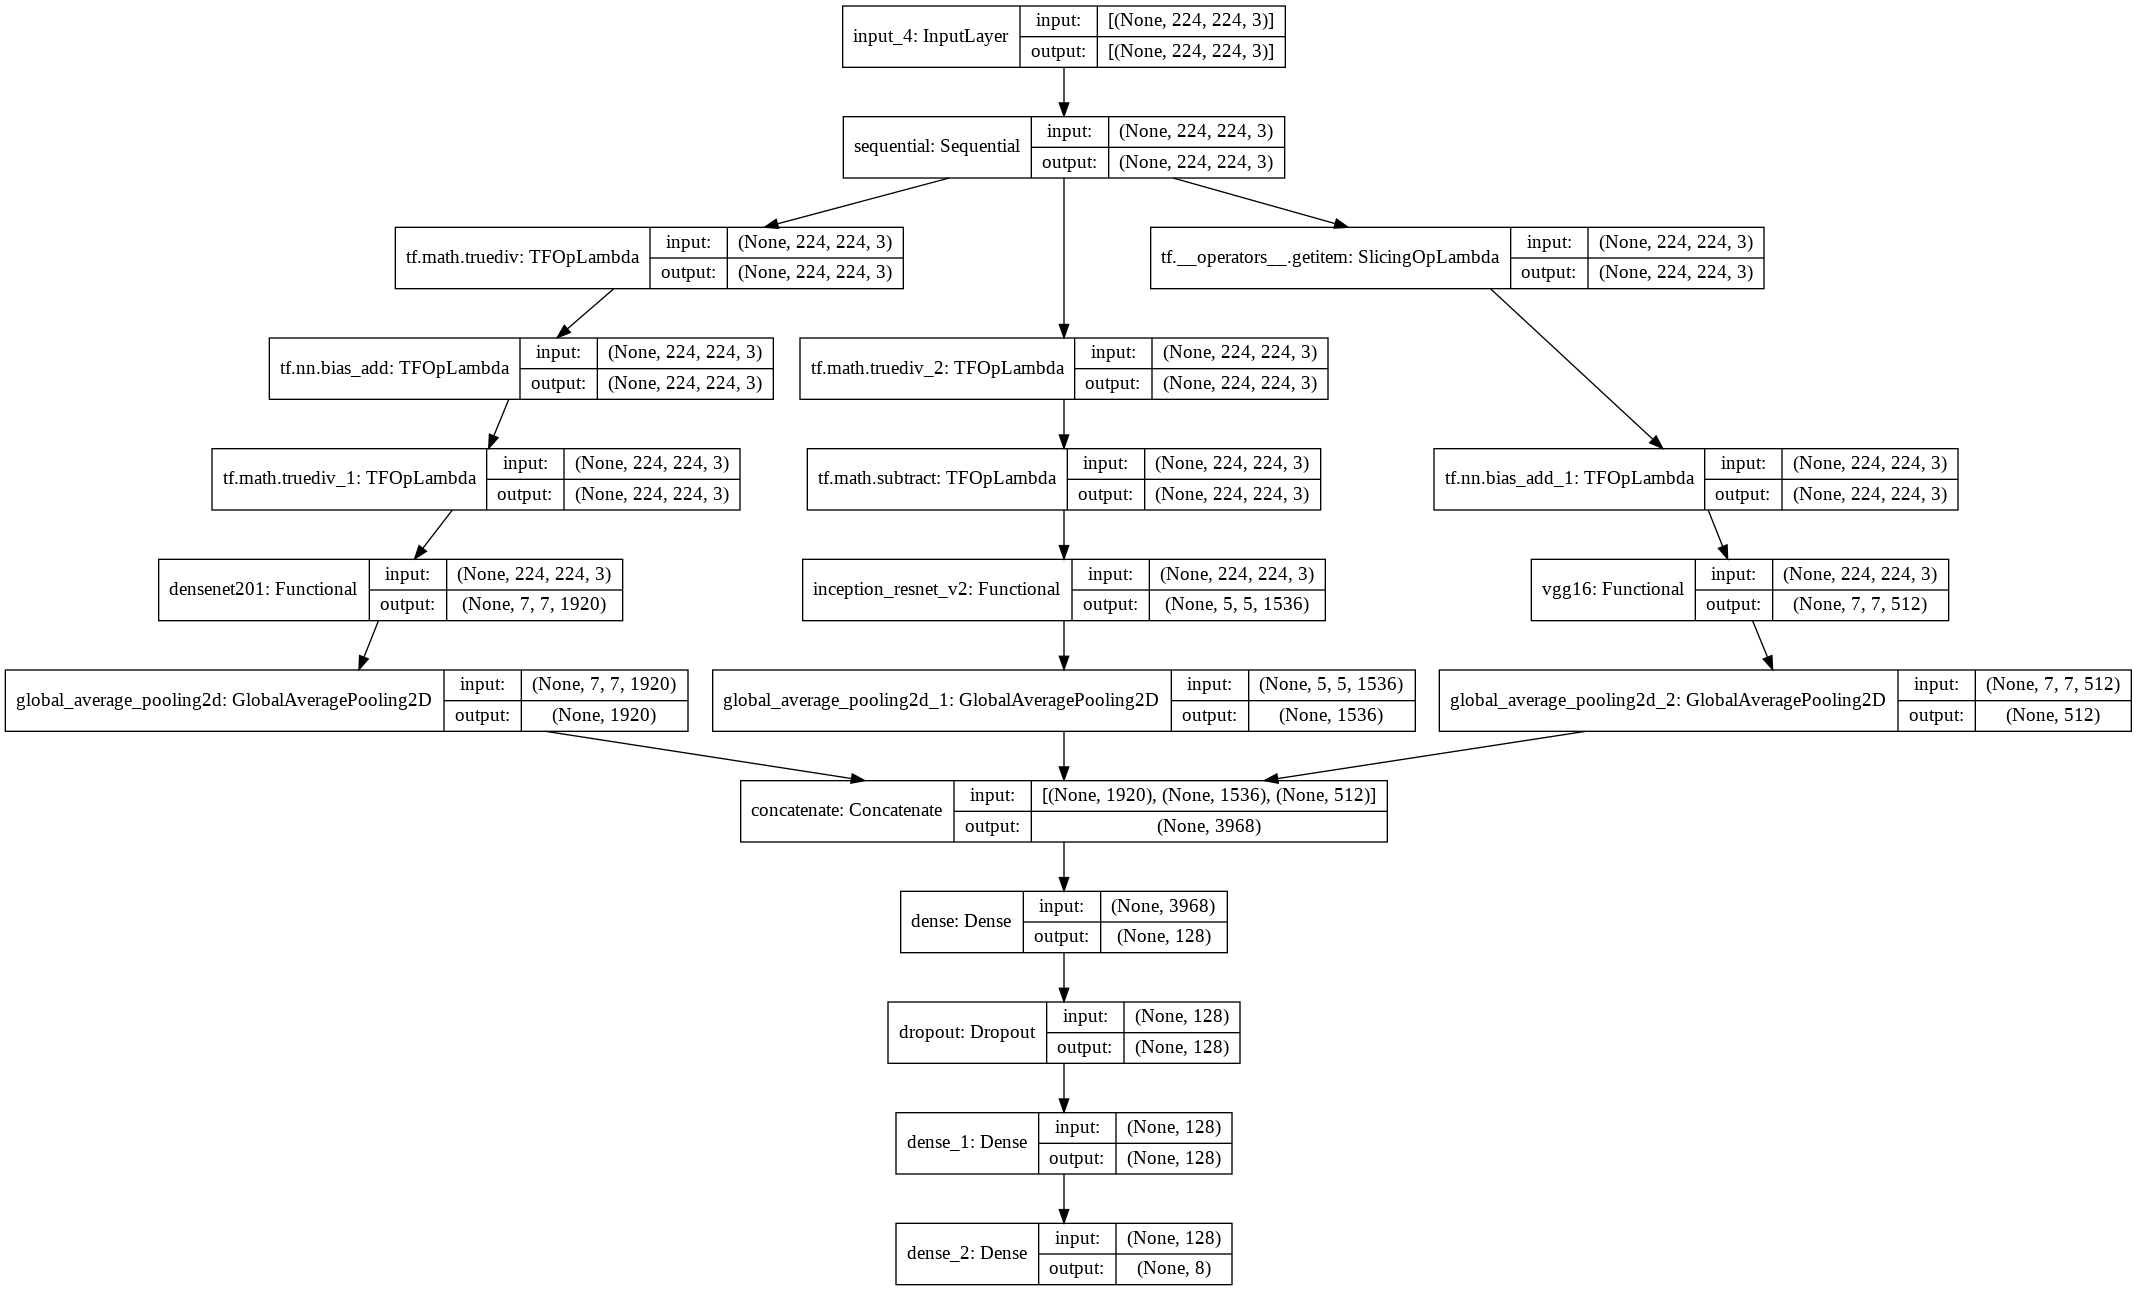

In [45]:
dot_img_file = 'GI-NetV2-927.png'
tf.keras.utils.plot_model(final_model, to_file=dot_img_file, show_shapes=True)